In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
import tensorflow as tf

from src.globals import processed_data_dir, saved_model_dir, vis_dir
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [21]:
from src.helpers import WindowGenerator, get_filenames_in_directory

In [7]:
train_files = get_filenames_in_directory(train_dir)

In [8]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) - 1 # number of columns without embedding column
n_features

11

In [9]:
# number of locations for embedding inputs
# 4
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

4

In [10]:
# Model configs
INPUT_WIDTH = 24
LABEL_WIDTH = 6
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [22]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')
w1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): ['Lufttemperatur [GradC]']

# Define model & metrics

In [12]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, 11))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([ embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)

# Slice out only the necessary number of timesteps
output = output(lstm_layer)[:,-LABEL_WIDTH:,:]

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

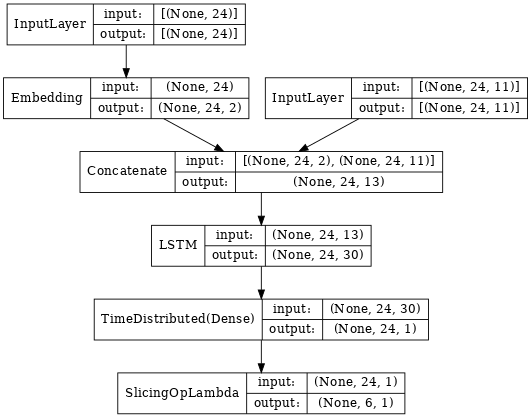

In [13]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'lstm.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

# Train model

In [14]:
# Train configs
MAX_EPOCHS = 30

In [15]:
METRICS = [
      tf.keras.metrics.MeanSquaredError(name='MSE'),
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [16]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=3, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [17]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/30
2188/2188 [==============================] - 135s 59ms/step - loss: 0.5695 - MSE: 0.5695 - MAE: 0.5815 - val_loss: 0.1269 - val_MSE: 0.1269 - val_MAE: 0.2736
Epoch 2/30
2188/2188 [==============================] - 85s 39ms/step - loss: 0.1040 - MSE: 0.1040 - MAE: 0.2479 - val_loss: 0.0989 - val_MSE: 0.0989 - val_MAE: 0.2421
Epoch 3/30
2188/2188 [==============================] - 96s 44ms/step - loss: 0.0847 - MSE: 0.0847 - MAE: 0.2221 - val_loss: 0.0874 - val_MSE: 0.0874 - val_MAE: 0.2263
Epoch 4/30
2188/2188 [==============================] - 117s 53ms/step - loss: 0.0760 - MSE: 0.0760 - MAE: 0.2091 - val_loss: 0.0801 - val_MSE: 0.0801 - val_MAE: 0.2153
Epoch 5/30
2188/2188 [==============================] - 97s 44ms/step - loss: 0.0707 - MSE: 0.0707 - MAE: 0.2009 - val_loss: 0.0753 - val_MSE: 0.0753 - val_MAE: 0.2075
Epoch 6/30
2188/2188 [==============================] - 101s 46ms/step - loss: 0.0669 - MSE: 0.0669 - MAE: 0.1949 - val_loss: 0.0719 - val_MSE: 0.0719 - val_M

In [18]:
model.save(str(saved_model_dir/model_name))

[2021-08-03 11:52:56 | save] Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.
[2021-08-03 11:52:56 | save] Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210803/assets


[2021-08-03 11:52:57 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210803/assets


Text(0, 0.5, 'val_loss')

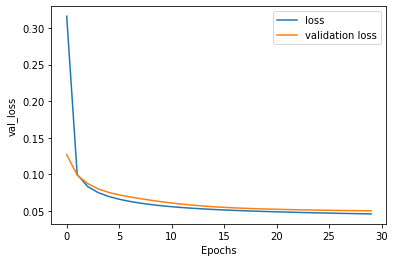

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [23]:
model.evaluate(w1.test)

1096/1096 [==============================] - 32s 29ms/step - loss: 0.0564 - MSE: 0.0564 - MAE: 0.1723


[0.05643870308995247, 0.056438688188791275, 0.17230410873889923]